In [ ]:
# Unzipping the Challenge Dataset
!unzip -q '/content/drive/MyDrive/Challenge_Dataset.zip'

###Data Processing

In [ ]:
# Importing Libraries for Processing
import cv2
from google.colab.patches import cv2_imshow
import os
import random
import imutils
import numpy as np

In [ ]:
# Training Data Pre-Processing & Augmentation
train_images, train_masks = [], []
directory = '/content/Challenge_Dataset/Images/Train'
directory2 = '/content/Challenge_Dataset/Masks/Train'
for image_name, mask_name in zip(os.listdir(directory),os.listdir(directory2)):
    file_path = os.path.join(directory, image_name)
    file_path2 = os.path.join(directory2, mask_name)
    image = cv2.imread(file_path) # convert image to pixels
    image2 = cv2.resize(image,(128,128)) # resizing 2d pixel grid
    image3 = image2/255.0 # normalize pixel values to 0-1
    a = random.choice([0,1,-1]) 
    image4 = cv2.flip(image3,a) # flip horizontally, vertically, or both
    b = random.choice(range(1,360)) # choose random angle from 1 to 359
    image5 = imutils.rotate(image3,b) # rotation by the chosen random angle
    train_images.extend([image3,image4,image5])
    mask = cv2.imread(file_path2) # convert mask to pixels
    mask2 = cv2.resize(mask,(128,128)) # resizing 2d pixel grid
    mask3 = mask2/255.0 # normalize pixel values to 0-1
    mask4 = cv2.flip(mask3,a) # flip along the axis same as for image
    mask5 = imutils.rotate(mask3,b) # rotate by the angle same as for image
    train_masks.extend([mask3,mask4,mask5])

In [ ]:
x_train = np.array(train_images)
del train_images
y_train = np.array(train_masks)
del train_masks

In [ ]:
# Validation Data Pre-Processing & Augmentation
val_images, val_masks = [], []
directory3 = '/content/Challenge_Dataset/Images/Validation'
directory4 = '/content/Challenge_Dataset/Masks/Validation'
for image_name, mask_name in zip(os.listdir(directory3),os.listdir(directory4)):
    file_path = os.path.join(directory3, image_name)
    file_path2 = os.path.join(directory4, mask_name)
    image = cv2.imread(file_path) # convert image to pixels
    image2 = cv2.resize(image,(128,128)) # resizing 2d pixel grid
    image3 = image2/255.0 # normalize pixel values to 0-1
    a = random.choice([0,1,-1]) 
    image4 = cv2.flip(image3,a) # flip horizontally, vertically, or both
    b = random.choice(range(1,360)) # choose random angle from 1 to 359
    image5 = imutils.rotate(image3,b) # rotation by the chosen random angle
    val_images.extend([image3,image4,image5])
    mask = cv2.imread(file_path2) # convert mask to pixels
    mask2 = cv2.resize(mask,(128,128)) # resizing 2d pixel grid
    mask3 = mask2/255.0 # normalize pixel values to 0-1
    mask4 = cv2.flip(mask3,a) # flip along the axis same as for image
    mask5 = imutils.rotate(mask3,b) # rotate by the angle same as for image
    val_masks.extend([mask3,mask4,mask5])

In [ ]:
x_val = np.array(val_images)
del val_images
y_val = np.array(val_masks)
del val_masks

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3000, 128, 128, 3),
 (3000, 128, 128, 3),
 (600, 128, 128, 3),
 (600, 128, 128, 3))

###Architecture

In [ ]:
# Imporying Libraries for building the network
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# A residual block as an encoder
def encoder_block(x, n_filters):
    fx = layers.Conv2D(n_filters, 3, padding = "same")(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.ReLU()(fx)
    fx = layers.Conv2D(n_filters, 3, padding = "same")(fx)
    fx = layers.BatchNormalization()(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    return out

In [ ]:
# A convolution block with 3 convolutions
def convolution_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [ ]:
# A decoder block (concatenation + convolution block + upsampling)
def decoder_block(x, conv_features, n_filters):
    x = layers.concatenate([x, conv_features])
    x = convolution_block(x, n_filters)
    x = layers.UpSampling2D(2,interpolation='bilinear')(x)
    return x

In [ ]:
# Single convolution encoder block (Conv2D+BN+ReLU)
def CBRM(x, n_filters):
  x = layers.Conv2D(n_filters, 3, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  return x

In [ ]:
# Single convolution decoder block (Concatenation+Conv2D+BN+ReLU+Upsampling)
def CBRU(x, conv_features, n_filters):
  x = layers.concatenate([x,conv_features])
  x = layers.Conv2D(n_filters, 3, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.UpSampling2D(2,interpolation='bilinear')(x)
  return x

In [ ]:
# Residual Refinement Module - A simple U-Net
def refunet(x):
  rx = layers.Conv2D(64, 3, padding = "same")(x)
  r1 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r1)
  r2 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r2)
  r3 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r3)
  r4 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r4)
  rx = layers.Conv2D(64, 3, padding = "same")(rx)
  rx = layers.BatchNormalization()(rx)
  rx = layers.ReLU()(rx)
  rx = layers.UpSampling2D(2,interpolation='bilinear')(rx)
  s4 = CBRU(rx,r4,64)
  s3 = CBRU(s4,r3,64)
  s2 = CBRU(s3,r2,64)
  sx = layers.concatenate([s2,r1])
  sx = layers.Conv2D(64, 3, padding = "same")(sx)
  sx = layers.BatchNormalization()(sx)
  s1 = layers.ReLU()(sx)
  residual = layers.Conv2D(3, 1, padding = "same")(s1)
  out = layers.Add()([x,residual])
  return out

In [ ]:
# Generate output mask at each decoding layer
def sideoutput(x, up_factor):
  x = layers.Conv2D(3, 1, padding = "same")(x)
  x = layers.UpSampling2D(up_factor, interpolation='bilinear')(x) # upsampling to output space
  x = layers.Activation('sigmoid')(x)
  return x

In [ ]:
# Boundary Aware Segmentation Network - Main Model (3 encoders + bottleneck + 3 decoders)
def BASNet():
  resnet_model = ResNet50(include_top = False, input_shape = (128,128,3)) # pre-trained resnet50 model
  resnet_model.trainable = False
  h1 = resnet_model.layers[38].output # encoder 1
  h2 = resnet_model.layers[80].output # encoder 2
  h3 = resnet_model.layers[142].output # encoder 3               
  hb = convolution_block(h3,1024) # bottleneck
  db = sideoutput(hb,16)
  hd3 = decoder_block(hb,h3,512) # decoder 3
  d3 = sideoutput(hd3,8)
  hd2 = decoder_block(hd3,h2,256) # decoder 2
  d2 = sideoutput(hd2,4)
  hy = layers.concatenate([hd2,h1])
  hy = convolution_block(hy,64)
  hd1 = layers.UpSampling2D(4,interpolation='bilinear')(hy) # decoder 1
  d1 = layers.Conv2D(3, 1, padding="same")(hd1)
  d1out = layers.Activation('sigmoid')(d1)
  dout = refunet(d1)
  out = layers.Activation('sigmoid')(dout)
  basnet_model = tf.keras.Model(inputs = resnet_model.inputs, outputs = [out,d1out,d2,d3,db])
  return basnet_model

In [ ]:
mynet_model = BASNet()
mynet_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

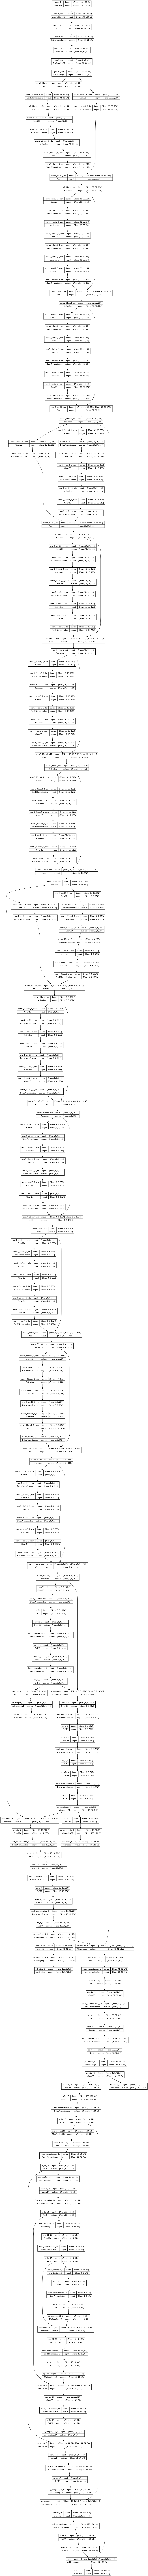

In [ ]:
tf.keras.utils.plot_model(mynet_model, show_shapes=True)

###Training

In [ ]:
from keras import backend as K

# T = True, F = False, P = Positives, N = Negatives

def recall(y_true, y_pred): # calculate recall = TP/(TP+FN)
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (actual_positives + K.epsilon())
  return recall

def precision(y_true, y_pred): # calculate precision = TP/(TP+FP)
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1score(y_true, y_pred): # calculate F1 Score = Dice Coefficient = 2PR/(P+R)
  P = precision(y_true, y_pred)
  R = recall(y_true, y_pred)
  return 2*((P*R)/(P+R+K.epsilon()))

def iouloss(y_true, y_pred):  
  dice = f1score(y_true, y_pred)
  iou = dice/(2-dice) # IoU = Intersection Over Union = F1/(2-F1)
  ioul = 1 - iou # calculate IoU Loss = Jaccard Loss = 1 - IoU
  return ioul

def ssim_loss(y_true, y_pred):
  ssim = tf.image.ssim(y_true, y_pred, 1) # SSIM = Structural Similarity Index Measure
  ssiml = 1 - tf.reduce_mean(ssim) # SSIM Loss = 1 - SSIM
  return ssiml

def custom_loss(y_true, y_pred):
  ssim = ssim_loss(y_true, y_pred)
  iou = iouloss(y_true, y_pred)
  l = tf.keras.losses.BinaryCrossentropy() # Binary Cross-Entropy Loss
  bce = l(y_true, y_pred)
  return ssim + iou + bce

In [ ]:
# calculate loss between predicted output at a layer and true mask, sum of the losses for the layers (i.e. equal weights) as the final loss term
losses = {"activation_4": custom_loss, "activation_3": custom_loss, "activation_2": custom_loss, "activation_1": custom_loss, "activation": custom_loss}
lossWeights = {"activation_4": 1, "activation_3": 1, "activation_2": 1, "activation_1": 1, "activation": 1}

In [ ]:
# Adam Optimisation with default settings, recoed the main metric F1 Score along with accuracy
mynet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=losses, loss_weights=lossWeights, metrics=['acc',f1score])

In [ ]:
# True Mask is the true label for all layer outputs
y_train_all = {"activation_4": y_train, "activation_3": y_train, "activation_2": y_train, "activation_1": y_train, "activation": y_train}
y_val_all = {"activation_4": y_val, "activation_3": y_val, "activation_2": y_val, "activation_1": y_val, "activation": y_val}

In [ ]:
# Train for 100 epochs with batch size as 10
model_history = mynet_model.fit(x = x_train, y = y_train_all, epochs = 100, validation_data = (x_val, y_val_all), batch_size=10)

Epoch 1/100
300/300 [==============================] - 77s 184ms/step - loss: 8.7082 - activation_4_loss: 1.7692 - activation_3_loss: 1.7953 - activation_2_loss: 1.7176 - activation_1_loss: 1.7180 - activation_loss: 1.7080 - activation_4_acc: 0.3297 - activation_4_f1score: 0.3623 - activation_3_acc: 0.2142 - activation_3_f1score: 0.4380 - activation_2_acc: 0.2871 - activation_2_f1score: 0.3991 - activation_1_acc: 0.3010 - activation_1_f1score: 0.4176 - activation_acc: 0.3321 - activation_f1score: 0.4073 - val_loss: 8.3893 - val_activation_4_loss: 1.6776 - val_activation_3_loss: 1.6698 - val_activation_2_loss: 1.6580 - val_activation_1_loss: 1.6965 - val_activation_loss: 1.6874 - val_activation_4_acc: 0.4982 - val_activation_4_f1score: 0.4889 - val_activation_3_acc: 0.3620 - val_activation_3_f1score: 0.4930 - val_activation_2_acc: 0.3697 - val_activation_2_f1score: 0.4952 - val_activation_1_acc: 0.2876 - val_activation_1_f1score: 0.4704 - val_activation_acc: 0.4127 - val_activation_f1sc

After training for 100 epochs,<br>
output loss (train) = 0.9340 (least),<br>
output f1 (train) = 0.7354 (max),<br>
output loss (val) = 2.0891 (least = 1.6369),<br>
output f1 (val) = 0.3061 (max = 0.4941)

In [ ]:
mynet_model.save('/content/drive/MyDrive/IE643/MyModel3/') # save the model

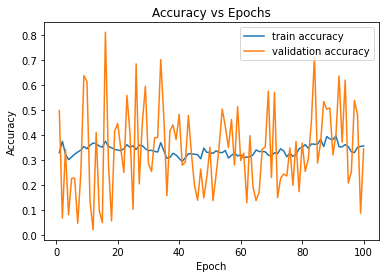

In [ ]:
epochs = range(1,101)
acc = model_history.history["activation_4_acc"]
val_acc = model_history.history["val_activation_4_acc"]
plt.plot(epochs, acc, label="train accuracy")
plt.plot(epochs, val_acc, label="validation accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

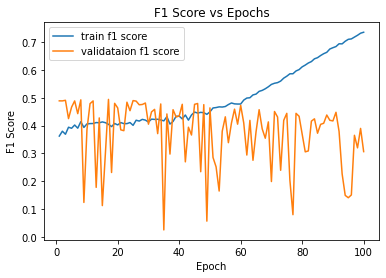

In [ ]:
# The loss function essentially trains the model to maximise F1 Score (not accuracy) as IoU and F1 are closely related
f1 = model_history.history["activation_4_f1score"]
val_f1 = model_history.history["val_activation_4_f1score"]
plt.plot(epochs, f1, label="train f1 score")
plt.plot(epochs, val_f1, label="validataion f1 score")
plt.title("F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

From this plot it seems the model is stilling undergoing training, and hasn't learnt optimum weights which can generalise the model to predict on new data (as the train f1 score keeps on increasing with epochs while validation f1 score in fact marginally decreases)

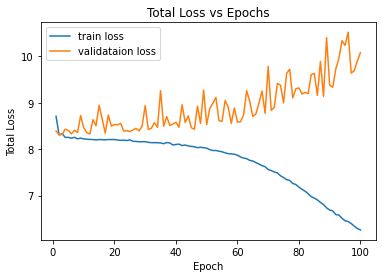

In [ ]:
tot_loss = model_history.history["loss"]
tot_val_loss = model_history.history["val_loss"]
plt.plot(epochs, tot_loss, label="train loss")
plt.plot(epochs, tot_val_loss, label="validataion loss")
plt.title("Total Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.legend()

Similar observation here: the training loss keeps on decreasing. However, the validation loss keeps on increasing which isn't desirable.

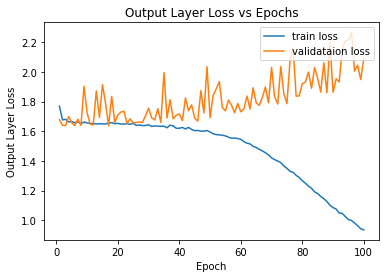

In [ ]:
out_loss = model_history.history["activation_4_loss"]
out_val_loss = model_history.history["val_activation_4_loss"]
plt.plot(epochs, out_loss, label="train loss")
plt.plot(epochs, out_val_loss, label="validataion loss")
plt.title("Output Layer Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Output Layer Loss")
plt.legend(loc="upper right")

The earlier plot was for total loss vs epochs. Whereas this plot is the loss between model prediction (final layer output) and true mask.

###Test+Load+Retrain

In [ ]:
image = cv2.imread('/content/Challenge_Dataset/Images/Train/c_0.jpg')
image = cv2.resize(image,(128,128))
test_image = np.reshape(image,(1,128,128,3))
image2 = cv2.imread('/content/Challenge_Dataset/Images/Validation/c_2.jpg')
image2 = cv2.resize(image2,(128,128))
test_image2 = np.reshape(image2,(1,128,128,3))
test_set = np.vstack((test_image,test_image2))
test_set.shape

(2, 128, 128, 3)

In [ ]:
mask = cv2.imread('/content/Challenge_Dataset/Masks/Train/c_0.png')
mask = cv2.resize(mask,(128,128))
test_mask = np.reshape(mask,(1,128,128,3))
mask2 = cv2.imread('/content/Challenge_Dataset/Masks/Validation/c_2.png')
mask2 = cv2.resize(mask2,(128,128))
test_mask2 = np.reshape(mask2,(1,128,128,3))
test_set_m = np.vstack((test_mask,test_mask2))
test_set_m.shape

(2, 128, 128, 3)

In [ ]:
TI = tf.convert_to_tensor(test_set, dtype=tf.float32)
TM = tf.convert_to_tensor(test_set_m, dtype=tf.float32)

As an example the first train and validation images and masks are taken as the testing set

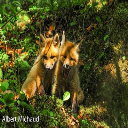

In [ ]:
cv2_imshow(test_image[0])

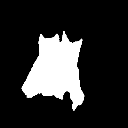

In [ ]:
cv2_imshow(test_mask[0])

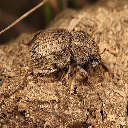

In [ ]:
cv2_imshow(test_image2[0])

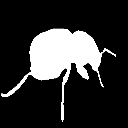

In [ ]:
cv2_imshow(test_mask2[0])

1/1 [==============================] - 2s 2s/step


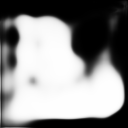

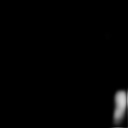

In [ ]:
pred = mynet_model.predict(TI)[0] # display mask predictions on test set
for mask in pred:
    cv2_imshow(cv2.cvtColor(mask*255, cv2.COLOR_BGR2GRAY))

In [ ]:
metrics = mynet_model.evaluate(TI,TM) # evaluate performance metrics on test set

1/1 [==============================] - 4s 4s/step - loss: -inf - activation_4_loss: -inf - activation_3_loss: -inf - activation_2_loss: -inf - activation_1_loss: -inf - activation_loss: -inf - activation_4_acc: 0.1441 - activation_4_f1score: 0.3874 - activation_3_acc: 0.0302 - activation_3_f1score: 0.3464 - activation_2_acc: 0.4460 - activation_2_f1score: 0.2700 - activation_1_acc: 0.5870 - activation_1_f1score: 0.4431 - activation_acc: 0.4555 - activation_f1score: 0.4792


In [ ]:
# load the trained model (from a drive folder)
model = keras.models.load_model('/content/drive/MyDrive/IE643/MyModel3',custom_objects={'f1score':f1score,'losses':losses,'lossWeights':lossWeights,'custom_loss':custom_loss})

In [ ]:
# Resume training for more 50 epochs
model_history2 = model.fit(x = x_train, y = y_train_all, epochs = 50, validation_data = (x_val, y_val_all), batch_size=10)

Epoch 1/50
300/300 [==============================] - 75s 181ms/step - loss: 7.5380 - activation_4_loss: 1.3886 - activation_3_loss: 1.3964 - activation_2_loss: 1.5123 - activation_1_loss: 1.6140 - activation_loss: 1.6268 - activation_4_acc: 0.3195 - activation_4_f1score: 0.5620 - activation_3_acc: 0.4154 - activation_3_f1score: 0.5724 - activation_2_acc: 0.3518 - activation_2_f1score: 0.5313 - activation_1_acc: 0.3675 - activation_1_f1score: 0.4642 - activation_acc: 0.3464 - activation_f1score: 0.4587 - val_loss: 9.7382 - val_activation_4_loss: 2.0423 - val_activation_3_loss: 1.8833 - val_activation_2_loss: 1.8923 - val_activation_1_loss: 1.9004 - val_activation_loss: 2.0199 - val_activation_4_acc: 0.8028 - val_activation_4_f1score: 0.1084 - val_activation_3_acc: 0.2832 - val_activation_3_f1score: 0.3590 - val_activation_2_acc: 0.3128 - val_activation_2_f1score: 0.3498 - val_activation_1_acc: 0.2696 - val_activation_1_f1score: 0.2888 - val_activation_acc: 0.3743 - val_activation_f1sco

After training for 150 epochs,<br>
output loss (train) = 0.4933 (least),<br>
output f1 (train) = 0.8781 (max),<br>
output loss (val) = 1.9822 (least = 1.6369),<br>
output f1 (val) = 0.3925 (max = 0.4941)

In [ ]:
model.save('/content/drive/MyDrive/IE643/MyModel4/') # save the model

1/1 [==============================] - 2s 2s/step


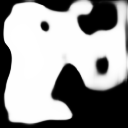

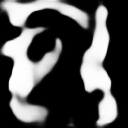

In [ ]:
pred2 = model.predict(TI)[0] # predict mask
for mask in pred2:
    cv2_imshow(cv2.cvtColor(mask*255, cv2.COLOR_BGR2GRAY))

In [ ]:
metrics = model.evaluate(TI,TM) # evaluate metric

1/1 [==============================] - 3s 3s/step - loss: -inf - activation_4_loss: -inf - activation_3_loss: -inf - activation_2_loss: -inf - activation_1_loss: -inf - activation_loss: -inf - activation_4_acc: 0.5343 - activation_4_f1score: 0.3556 - activation_3_acc: 0.8499 - activation_3_f1score: 0.3363 - activation_2_acc: 0.5403 - activation_2_f1score: 0.2901 - activation_1_acc: 0.7682 - activation_1_f1score: 0.3947 - activation_acc: 0.6949 - activation_f1score: 0.3039
